In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from shapley.plots import set_style_paper, plot_sensitivity_results
set_style_paper()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from shapley.tests import AdditiveGaussian, Ishigami
from shapley.tests.utils import true_gaussian_full_ind_sobol

Model = AdditiveGaussian

if Model == AdditiveGaussian:
    dim = 3
    beta = None
    model = Model(dim=dim, beta=beta)
    model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., 0.5]
    #true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
#     true_indices = {'full': true_full_indices,
#                     'ind': true_ind_indices}
    model.copula_parameters = theta
elif Model == Ishigami:
    model = Model()
    dim = model.dim
    model.copula = ot.NormalCopula(dim)
    theta = [0., 0., 0.]

In [3]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

shapley_method = 'random'

n_var = 1000
n_inner = 3
if shapley_method == 'exact':
    n_perms = None
    n_outer = 100
else:
    n_perms = 600
    n_outer = 1

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 4600
CPU times: user 2.04 s, sys: 1.02 s, total: 3.06 s
Wall time: 1.04 s


In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 1000
shapley_results = shapley.compute_indices(n_boot=n_boot)
shapley_results._shapley_indices = None

CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.8 s


In [5]:
%%time
from shapley import SobolIndices

ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = int(max_budget / (dim*4))

sobol = SobolIndices(model.input_distribution)
# Generate the samples
sobol.build_uncorr_sample(model=model, n_sample=n_sample)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 10.3 ms


In [25]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
all_sobol_results = {}

estimator = 'sobolmara'

for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    all_sobol_results[indice_type] = results

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 61.2 ms


In [26]:
sobol_results = all_sobol_results['full']
sobol_results.total_indices = all_sobol_results['ind']._total_indices
sobol_results.true_total_indices = all_sobol_results['ind'].true_total_indices

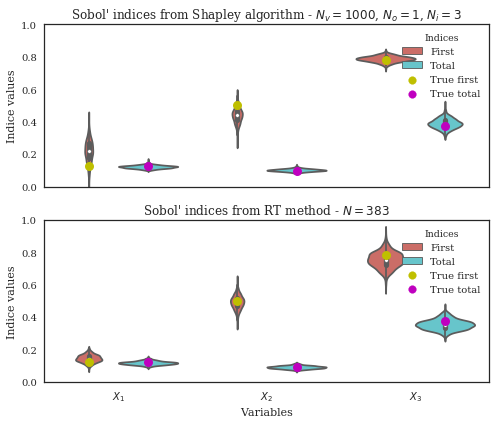

In [27]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

names = ['Shapley algorithm', 'RT method']

fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True, sharey=True)
for i, results in enumerate([shapley_results, sobol_results]):
    ax = axes[i]
    plot_sensitivity_results(results, ax=ax)
    figname = "Sobol' indices from "
    if i == 0:
        figname += 'Shapley algorithm - $N_v=%d$, $N_o=%d$, $N_i=%d$' % (n_var, n_outer, n_inner)
    else:        
        figname += 'RT method - $N=%d$' % (n_sample)
    ax.set_title(figname)
    ax.set_ylim(ylim)
    
axes[0].set_xlabel('')
fig.tight_layout()
fig.savefig('./output/Additive_Gaussian_shapley_sobol_%s.pdf' % (estimator))

In [98]:
for results in [shapley_results, sobol_results]:
    print(results.full_total_indices[:, 0] - results.true_total_indices)

[-0.02854922  0.00264453  0.01062592]
[-0.01382314 -0.01095215 -0.01301219]


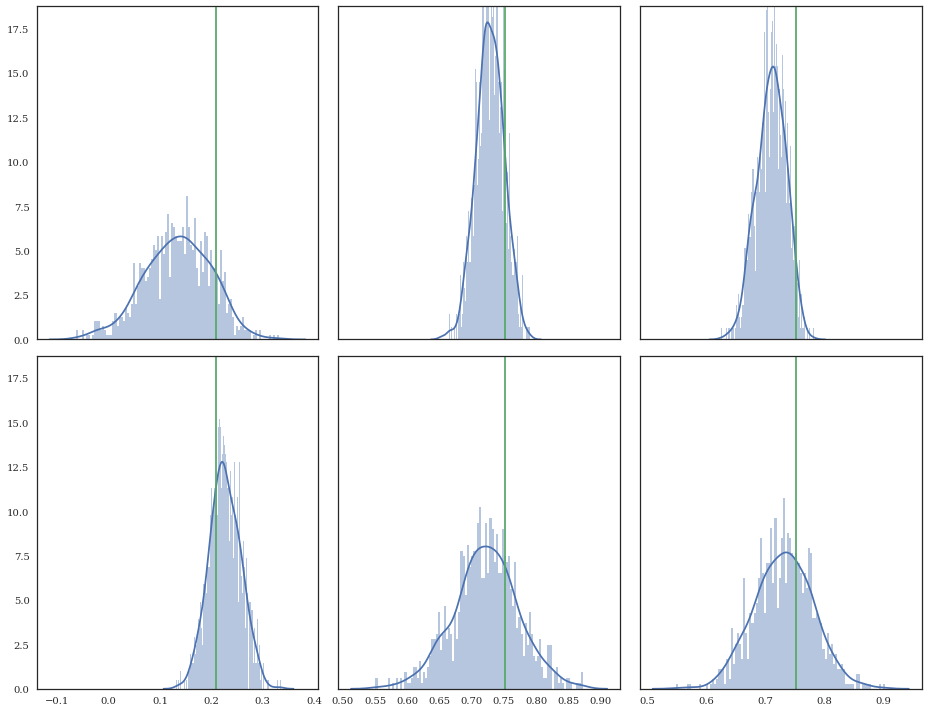

In [30]:
fig, axes = plt.subplots(2, dim, figsize=(13, 10), sharex='col', sharey=True)
for i in range(dim):
    for j, results in enumerate([shapley_results, sobol_results]):
        ax = axes[j, i]
        sns.distplot(pd.DataFrame(results.full_first_indices[i, 1:]), bins=100, norm_hist=True, ax=ax); 
        ax.plot([results.true_first_indices[i]]*2, [0, 100])
fig.tight_layout()

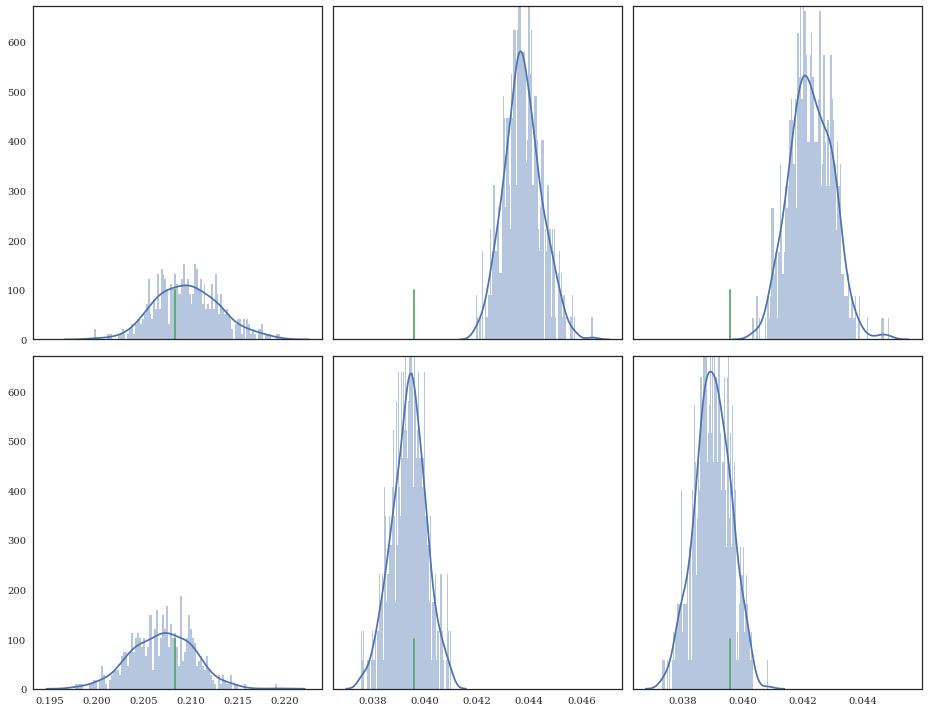

In [11]:
fig, axes = plt.subplots(2, dim, figsize=(13, 10), sharex='col', sharey=True)
for i in range(dim):
    for j, results in enumerate([shapley_results, sobol_results]):
        ax = axes[j, i]
        sns.distplot(pd.DataFrame(results.full_total_indices[i, 1:]), bins=100, norm_hist=True, ax=ax); 
        ax.plot([results.true_total_indices[i]]*2, [0, 100])
fig.tight_layout()